# Density estimation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from sklearn.covariance import EmpiricalCovariance
from scipy.stats import multivariate_normal
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold

## 1. Using the mean integrated squared error (MISE) estimate the density of data in kernel.csv with the Epanechnikov kernel.

In [3]:
dkernel=pd.read_csv('kernel.csv')
dkernel.head()

,X
0,-0.291617
1,2.486570
2,-2.666418
3,-6.363459
4,-1.196318


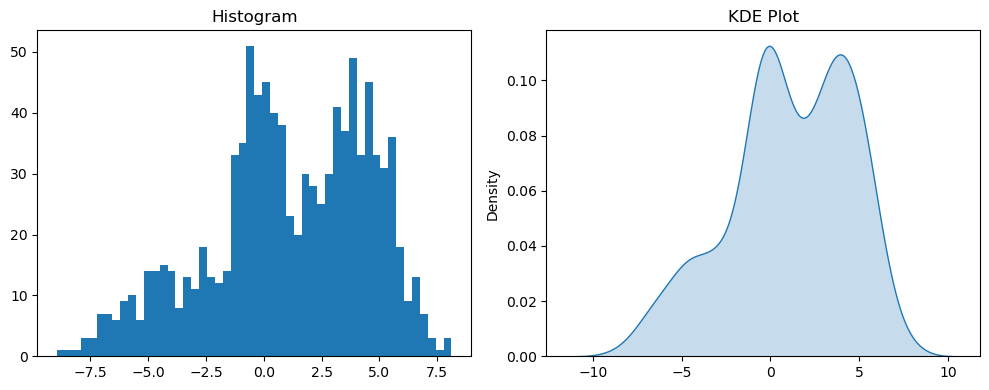

In [25]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot histogram on the first subplot
axes[0].hist(dkernel,bins=50)
axes[0].set_title('Histogram')

# Plot KDE (Kernel Density Estimate) on the second subplot
sns.kdeplot(dkernel, ax=axes[1], fill=True, legend=False)
axes[1].set_title('KDE Plot')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

Epanechnikov kernel function:

In [27]:
def K(u):#Epanechnikov kernel
    return list(map(lambda x: 0 if abs(x)>1 else 0.75 * (1-x**2),u))

We define the kernel density function (KDF):

In [28]:
def f_b(x, xn, b, K):
  return(1/b * np.array([np.mean(K((x_ - xn) / b)) for x_ in x]))

Where:

- x is the value at which the density is estimated
- xn is the array of data points
- b is the bandwidth or smoothing parameter
- K(u) is the kernel

We calculate p(-5) as an example using a kernel bandwith of 0.9

In [22]:
x = np.array([-5])
xn=dkernel.to_numpy()[:,0]
b=0.9
f_b(x,xn,b,K2)

array([0.03414818])

We can write MISE as:

$\mathrm{MISE}(\hat{f}) = \int\hat{f}^2\mathrm{(x)}d\mathrm{(x)} -2 \frac{1}{N}\sum_{i=1}^{N}\hat{f}^{(i)} (\mathrm{x}_i)$

Where:
- $\int\hat{f}^2\mathrm{(x)}d\mathrm{(x)}$ is a puntual estimator 

- $\frac{1}{N}\sum_{i=1}^{N}\hat{f}^{(i)} (\mathrm{x}_i)$ is the leave one out estimate, where $\hat{f}^{(i)}$ is the estimate using all examples except $\mathrm{x}_i$

In [58]:
def cost_function(xn, b, K):
    sd_ = np.std(xn)
    l_int = np.min(xn) - 1.5 * sd_#lowerbound
    u_int = np.max(xn) + 1.5 * sd_#upperbound
    f_est = lambda x : f_b(x, xn, b, K)
    steps_ = 1000
    I1 = np.sum(f_est(np.linspace(l_int, u_int, steps_))**2) * (u_int-l_int) / steps_ #multiplied by (u_int-l_int) / steps_ to make it independent of the number of steps_
    I2 = np.mean(np.array([ f_b([xn[i]], xn[ind != i], b, K) for i in ind ])) #leave one out estimate
    return(I1 - 2 * I2)

We define a range of bandwidths and compute the cost of each one.

In [59]:
%%time
b = np.arange(0.1,1.5, 0.02)
cost = np.array([cost_function(xn, b_, K2) for b_ in b])

Wall time: 52 s


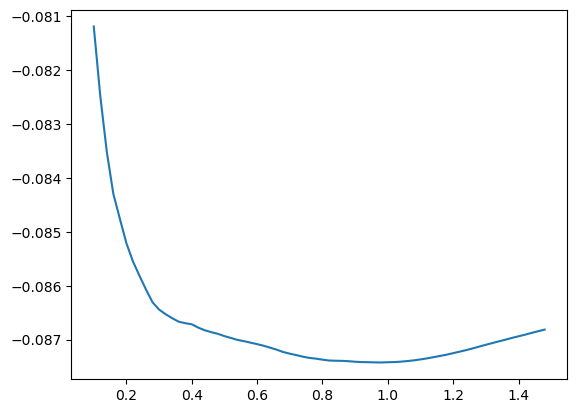

In [60]:
plt.plot(b, cost)
plt.show()

The optimum value of kernel bandwidth is the minimum

In [65]:
print('Kernel bandwidth:', round(b[np.argmin(cost)],2))

Kernel bandwidth: 0.98


We estimate the probability density function (PDF) from the histogram:

In [67]:
m = [{'p' : 0.2, 'norm' : multivariate_normal(mean=-4, cov=2**2)},
     {'p' : 0.3, 'norm' : multivariate_normal(mean= 0, cov=1)},
     {'p' : 0.5, 'norm' : multivariate_normal(mean= 4, cov=1.5**2)}]

In [75]:
x = np.arange(-10,10,0.01)
x.shape

(2000,)

Compute the density of 2000 points in the range -10,10

In [77]:
px = np.zeros(x.shape)
for i in np.arange(3):
  px = px + m[i]['p'] * m[i]['norm'].pdf(x)
print(round(np.sum(px),1))

100.0


Compute the density of each point using the Epanechnikov kernel and a bandwidth of 0.98

In [78]:
px_ = f_b(x, dkernel.to_numpy()[:,0], 0.98, K)

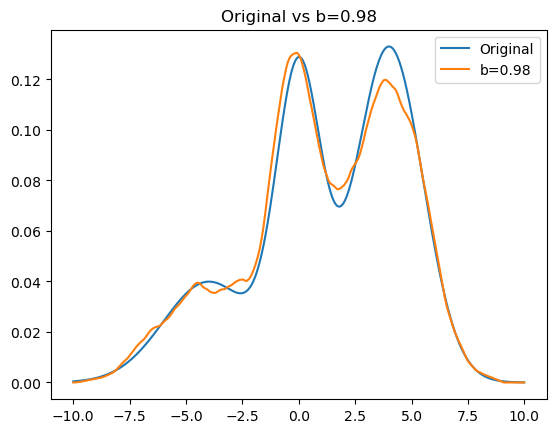

In [81]:
plt.title('Original vs b=0.98')
plt.plot(x,px)
plt.plot(x,px_)
plt.legend(['Original','b=0.98'])
plt.show()

## 2. We have seen that the BIC and MISE criterion can be used to decide about the hyperparameters of a mixture of Gaussian distributions and a kernel density, respectively. Another approach consists in evaluating the likelihood of a set of new examples not used to fit the models. Use a K-fold cross-validation approach to tune the hyperparameters of both methods.

In [82]:
diabetes=pd.read_csv('diabetes.csv')
diabetes.head()

,rw,fpg,glucose,insulin,sspg,group
0,0.81,80,356,124,55,normal
1,0.95,97,289,117,76,normal
2,0.94,105,319,143,105,normal
3,1.04,90,356,199,108,normal
4,1.00,90,323,240,143,normal


In [83]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   rw       145 non-null    float64
 1   fpg      145 non-null    int64  
 2   glucose  145 non-null    int64  
 3   insulin  145 non-null    int64  
 4   sspg     145 non-null    int64  
 5   group    145 non-null    object 
dtypes: float64(1), int64(4), object(1)
memory usage: 6.9+ KB


In [84]:
X=diabetes.drop(columns='group')

In [86]:
kf = KFold(n_splits=3)
for x, y in kf.split(X):
    print(y)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]
[49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
[ 97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144]


In [87]:
X[X.index.isin([49,50])]

,rw,fpg,glucose,insulin,sspg
49,0.87,87,360,292,128
50,0.87,94,313,200,233


In [103]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

3-Fold CV:

In [119]:
%%time
i=0
max_score = -np.infty
model_scores=[]
kf = KFold(n_splits=3)
n_components_range = range(1, 4)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=0, 
                          covariance_type=cv_type, n_init=20, 
                          max_iter = 1000)#instantiate a GMM object
        scores=[]
        for x, y in kf.split(X):#Split data
            GMM=gmm.fit(X[X.index.isin(x)])#Fit GMM to training
            scores.append(round(np.mean(GMM.score_samples(X[X.index.isin(y)])),2))##Compute the log-likelihood of each sample for each test fold and append the mean.
            i+=1
        #print(len(y))
        print('CV type:'+cv_type,', n-components:',n_components,scores,'Log-likelihood:' ,round(np.mean(scores),2))
        model_scores.append(round(np.mean(scores),2))#Compute mean log-likelihood score across all folds
        if model_scores[-1]>max_score:#Select the best model the one with highest mean log-likelihood across test folds.
            max_score=model_scores[-1]
            best_gmm=gmm

CV type:spherical , n-components: 1 [-32.38, -31.7, -74.69] Log-likelihood: -46.26
CV type:spherical , n-components: 2 [-29.36, -29.66, -56.51] Log-likelihood: -38.51
CV type:spherical , n-components: 3 [-27.27, -29.36, -92.32] Log-likelihood: -49.65
CV type:tied , n-components: 1 [-22.43, -23.03, -160.84] Log-likelihood: -68.77
CV type:tied , n-components: 2 [-21.87, -22.6, -167.8] Log-likelihood: -70.76
CV type:tied , n-components: 3 [-21.29, -22.1, -167.93] Log-likelihood: -70.44
CV type:diag , n-components: 1 [-24.57, -24.54, -151.99] Log-likelihood: -67.03
CV type:diag , n-components: 2 [-22.35, -22.0, -133.87] Log-likelihood: -59.41
CV type:diag , n-components: 3 [-20.46, -21.3, -144.76] Log-likelihood: -62.17
CV type:full , n-components: 1 [-22.43, -23.03, -160.84] Log-likelihood: -68.77
CV type:full , n-components: 2 [-20.97, -21.6, -209.89] Log-likelihood: -84.15
CV type:full , n-components: 3 [-20.99, -21.88, -135.12] Log-likelihood: -59.33
Wall time: 14.9 s


In [120]:
best_gmm.get_params()

{'covariance_type': 'spherical',
 'init_params': 'kmeans',
 'max_iter': 1000,
 'means_init': None,
 'n_components': 2,
 'n_init': 20,
 'precisions_init': None,
 'random_state': 0,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

In [121]:
print(np.sum(best_gmm.score_samples(X)))

-5274.356010078151


5-Fold CV:

In [122]:
%%time
i=0
max_score = -np.infty
model_scores=[]
kf = KFold(n_splits=5)
n_components_range = range(1, 4)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=0, 
                          covariance_type=cv_type, n_init=20, 
                          max_iter = 1000)#instantiate a GMM object
        scores=[]
        for x, y in kf.split(X):#Split data
            GMM=gmm.fit(X[X.index.isin(x)])#Fit GMM to training
            scores.append(round(np.mean(GMM.score_samples(X[X.index.isin(y)])),2))#Compute the log-likelihood of each sample for each test fold and append the mean.
            i+=1
        #print(len(y))
        print('CV type:'+cv_type,', n-components:',n_components,scores,'Log-likelihood:' ,round(np.mean(scores),2))
        model_scores.append(round(np.mean(scores),2))#Compute mean log-likelihood score across all folds
        if model_scores[-1]>max_score:#Select the best model the one with highest mean log-likelihood across test folds.
            max_score=model_scores[-1]
            best_gmm=gmm

CV type:spherical , n-components: 1 [-31.7, -31.78, -31.27, -32.86, -49.11] Log-likelihood: -35.34
CV type:spherical , n-components: 2 [-28.35, -28.7, -28.77, -34.46, -37.91] Log-likelihood: -31.64
CV type:spherical , n-components: 3 [-25.74, -26.47, -28.81, -31.06, -46.47] Log-likelihood: -31.71
CV type:tied , n-components: 1 [-21.63, -21.96, -22.47, -23.59, -31.65] Log-likelihood: -24.26
CV type:tied , n-components: 2 [-20.94, -21.22, -21.93, -23.92, -46.99] Log-likelihood: -27.0
CV type:tied , n-components: 3 [-20.38, -20.67, -21.46, -23.7, -47.09] Log-likelihood: -26.66
CV type:diag , n-components: 1 [-23.87, -23.95, -23.82, -25.5, -38.2] Log-likelihood: -27.07
CV type:diag , n-components: 2 [-21.05, -21.31, -21.02, -26.39, -96.76] Log-likelihood: -37.31
CV type:diag , n-components: 3 [-19.35, -20.02, -21.37, -22.85, -86.2] Log-likelihood: -33.96
CV type:full , n-components: 1 [-21.63, -21.96, -22.47, -23.59, -31.65] Log-likelihood: -24.26
CV type:full , n-components: 2 [-20.08, -2

In [123]:
best_gmm.get_params()

{'covariance_type': 'tied',
 'init_params': 'kmeans',
 'max_iter': 1000,
 'means_init': None,
 'n_components': 1,
 'n_init': 20,
 'precisions_init': None,
 'random_state': 0,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

In [124]:
print(np.sum(best_gmm.score_samples(X)))

-3391.7030397759277


10-Fold CV:

In [125]:
%%time
i=0
max_score = -np.infty
model_scores=[]
kf = KFold(n_splits=10)
n_components_range = range(1, 4)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=0, 
                          covariance_type=cv_type, n_init=20, 
                          max_iter = 1000)#instantiate a GMM object
        scores=[]
        for x, y in kf.split(X):#Split data
            GMM=gmm.fit(X[X.index.isin(x)])#Fit GMM to training
            scores.append(round(np.mean(GMM.score_samples(X[X.index.isin(y)])),2))#Compute the log-likelihood of each sample for each test fold and append the mean.
            i+=1
        #print(len(y))
        print('CV type:'+cv_type,', n-components:',n_components,scores,'Log-likelihood:' ,round(np.mean(scores),2))
        model_scores.append(round(np.mean(scores),2))#Compute mean log-likelihood score across all folds
        if model_scores[-1]>max_score:#Select the best model the one with highest mean log-likelihood across test folds.
            max_score=model_scores[-1]
            best_gmm=gmm

CV type:spherical , n-components: 1 [-31.41, -31.3, -31.4, -31.36, -30.84, -31.48, -31.24, -35.37, -36.49, -42.76] Log-likelihood: -33.36
CV type:spherical , n-components: 2 [-28.0, -27.89, -28.2, -28.27, -27.77, -31.29, -34.18, -33.4, -35.0, -33.69] Log-likelihood: -30.77
CV type:spherical , n-components: 3 [-25.26, -25.52, -26.28, -26.21, -27.45, -30.26, -31.88, -31.16, -34.45, -33.4] Log-likelihood: -29.19
CV type:tied , n-components: 1 [-21.42, -21.44, -21.78, -21.37, -21.57, -24.26, -23.36, -23.35, -23.54, -29.82] Log-likelihood: -23.19
CV type:tied , n-components: 2 [-20.7, -20.7, -21.04, -20.63, -20.89, -23.78, -22.86, -23.89, -26.66, -29.99] Log-likelihood: -23.11
CV type:tied , n-components: 3 [-20.13, -20.17, -20.5, -20.02, -20.4, -23.32, -22.3, -23.89, -26.88, -29.22] Log-likelihood: -22.68
CV type:diag , n-components: 1 [-23.56, -23.62, -23.7, -23.4, -23.17, -24.99, -25.09, -25.65, -26.83, -32.26] Log-likelihood: -25.23
CV type:diag , n-components: 2 [-20.68, -20.65, -21.08

In [126]:
best_gmm.get_params()

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 1000,
 'means_init': None,
 'n_components': 3,
 'n_init': 20,
 'precisions_init': None,
 'random_state': 0,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

In [127]:
print(np.sum(best_gmm.score_samples(X)))

-2973.131202412871


Covariance_type and n_components hyperparameters of the best model vary depending on the number of folds chosen. However, the best model is the one fitted with 10-kfold CV as the total sum of sample log-likelihood is the highest, -2973.

Now we use Kfold CV to tune the bandwidth of Epanechnikov kernel.

In [153]:
kf = KFold(n_splits=5,shuffle=True)
d={}
for b in np.arange(0.1,1.5, 0.02):
    logpx=[]
    for train, test in kf.split(xn):
        px=f_b(xn[test], xn[train], b, K)#Estimate the density of each test point, given train points.
        logpx.append(np.sum(np.log(px)))#Append the sum of log-likelihoods in the test fold.
    d["%.2f" % round(b, 2)]=np.sum(logpx).round(2)#key: b, value: sum of log-likelihoods across all folds

C:\Users\David\AppData\Local\Temp\ipykernel_11840\268431442.py:7: RuntimeWarning: divide by zero encountered in log
  logpx.append(np.sum(np.log(px)))#Append the sum of log-likelihoods in the test fold.


In [154]:
print(max(d, key=d.get))
print(d[max(d, key=d.get)])

1.00
-2575.95


The estimated bandwidth is very close to the value of 0.98 computed with MISE.

With a Gaussian Kernel:

In [148]:
def K1(u):
  return(1/np.sqrt(2*np.pi) * np.exp(-u**2 / 2))

In [151]:
kf = KFold(n_splits=5,shuffle=True)
d={}
for b in np.arange(0.1,1.5, 0.02):
    logpx=[]
    for train, test in kf.split(xn):
        px=f_b(xn[test], xn[train], b, K1)#Estimate the density of each test point, given train points.
        logpx.append(np.sum(np.log(px)))#Append the sum of log-likelihoods in the test fold.
    d["%.2f" % round(b, 2)]=np.sum(logpx).round(2)#key: b, value: sum of log-likelihoods across all folds

In [152]:
print(max(d, key=d.get))
print(d[max(d, key=d.get)])

0.42
-2574.84
